## Set Up 

In [1]:
from pythonosc import dispatcher, osc_server
from pythonosc.udp_client import SimpleUDPClient
import time

from bitalino import BITalino
import biofeatures

In [ ]:
macAddress = "/dev/tty.BITalino-DevB"

running_time = 120
    
acqChannels = [1,2]
samplingRate = 100
nSamples = 100

# Calculate features every 10 seconds
feature_interval = 10
feature_time = 0

# Connect to BITalino
device = BITalino(macAddress)

start = time.time()
end = time.time()

inflating = False
inflating_start_time = time.time()

data = []
features = []
trends = {}


# ECG

In [ ]:
# Start Acquisition
device.start(samplingRate, acqChannels)

try:
    while (end - start) < running_time:
        start_loop = time.time()
        
        new_samples = device.read(nSamples)
        new_signal = [s[-1] for s in new_samples]
    
        data += new_signal
        
        if inflating and (time.time() - inflating_start_time) > 5:
            client.send_message("/actuator/1/inflate", -50.0)
            print("deflating")
            inflating = False
        
        if feature_time > feature_interval:
            data = data[-samplingRate*5*60:]

            intervals = biofeatures.r_peak_intervals(data, samplingRate)

            new_features = biofeatures.hrv_features(intervals)
            features.append(new_features)
            print(new_features)
            
            if (end - start) > 1 * 60:
                
                for key in features[0].keys():
                    trends[key] = biofeatures.detect_trend([f[key] for f in features])
        
                if trends["rmssd"] < 0:
                    print("detected increase in anxiety")
                    
                if not inflating:
                    client.send_message("/actuator/1/inflate", 50.0)
                    print("inflating")
                    inflating_start_time = time.time()
                    inflating = True
                    
            
            feature_time = 0
        
        
        feature_time += time.time() - end
        end = time.time()

        end_loop = time.time()

except:
    print("Data processing crashed")

finally:   
    # Stop acquisition
    device.stop()
    
    # Close connection
    device.close()

In [ ]:
deflating = False

def print_volume_handler(unused_addr, args, volume):
    global deflating, deflateStartTime
    
    print("[{0}] ~ {1}".format(args, volume))
    
    if (volume > 1090 or deflating):
        client.send_message("/actuator/1/inflate", -80.0)   # Send float message between -100 and 100
        
        if deflating == False:
            deflating = True
            deflateStartTime = time.time()
        
        elif time.time() - deflateStartTime > 5:
            deflating = False
            
    elif deflating == False:
        client.send_message("/actuator/1/inflate", 80.0)   # Send float message between -100 and 100


deflateStartTime = time.time()
    
ip = "192.168.0.106"
port = 32000

client = SimpleUDPClient(ip, port)  # Create client
    
dispatcher = dispatcher.Dispatcher()
dispatcher.map("/sensor/pressure", print_volume_handler, "Pressure")

server = osc_server.ThreadingOSCUDPServer(("192.168.0.106", 31000), dispatcher)
print("Serving on {}".format(server.server_address))
server.serve_forever()

# Breathing

In [2]:
resp_data = []
last_update = time.time()

update_freq = 0.5

riot_ip = '192.168.0.102'
riot_port = 31000
actuator_port = 32000
actuator_ip = '192.168.0.102'

client = SimpleUDPClient(actuator_ip, actuator_port) 

inflated = False
inflating = False
deflating = False

In [3]:
def process_riot_data(unused_addr, *values):
    global resp_data, last_update, client, inflated, inflating, deflating
        
    new_data = values[12]
    resp_data.append(new_data)
        
    if len(resp_data) > 200*10 and time.time() - last_update > update_freq:
        last_int, breathe_in = biofeatures.resp_intervals(resp_data, sampling_rate = 200, last_breath = True)
                
        if breathe_in:
            print("Breathing in")
            client.send_message("/actuator/inflate", 100.0)
            inflating = True
            deflating = False
        else:
            print("Breathing out")
            client.send_message("/actuator/inflate", -100.0)
            deflating = True
            inflating = False
        
        last_update = time.time()
    
    # only save the last 5 min of data
    if len(resp_data) > 200 * 60 * 5:
        resp_data = resp_data[-200*60*5:]

In [4]:
def handle_pressure(unused_addr, pressure):
    global client, inflated, inflating, deflating
    print(pressure)
    
    if pressure < 800:
        print("Fully deflated!")
        client.send_message("/actuator/inflate", 0.0)
        deflating = False
    
    elif deflating and pressure > 1000:
        print("Squeeze!")
        
    elif pressure > 1200:
        print("Careful!")
        client.send_message("/actuator/inflate", -90.0)
        deflating = True
        
    elif not deflating:
        client.send_message("/actuator/inflate", 100.0)

In [5]:
riot_dispatcher = dispatcher.Dispatcher()
#riot_dispatcher.map("/*/raw", process_riot_data)
riot_dispatcher.map("/sensor/pressure", handle_pressure)

server = osc_server.ThreadingOSCUDPServer((riot_ip, riot_port), riot_dispatcher)
print("Serving on {}".format(server.server_address))
server.serve_forever()

Serving on ('192.168.0.102', 31000)
1017.7318115234375
1030.5379638671875
1071.9437255859375
1075.48046875
1072.45556640625
1070.5350341796875
1066.88427734375
1067.255615234375
1070.3162841796875
1071.708984375
1071.189453125
1070.10009765625
1068.54150390625
1069.43896484375
1071.2506103515625
1072.7764892578125
1070.8111572265625
1066.515625
1070.6488037109375
1070.2135009765625
1070.6494140625
1066.076904296875
1066.124267578125
1066.244140625
1070.752197265625
1071.05712890625
1071.260009765625
1067.1904296875
1065.51708984375
1068.494140625
1071.044189453125
1070.8529052734375
1068.11328125
1065.6602783203125
1067.6600341796875
1070.5068359375
1071.1741943359375
1069.54052734375
1066.0740966796875
1066.3670654296875
1069.3626708984375
1071.8056640625
1070.5902099609375
1066.46630859375
1066.7904052734375
1069.45556640625
1072.1572265625
1070.351318359375
1066.087646484375
1066.5225830078125
1069.3802490234375
1071.63330078125
1070.027099609375
1065.6658935546875
1066.649291992187

1029.7088623046875
Squeeze!
1031.646240234375
Squeeze!
1033.995849609375
Squeeze!
1038.0877685546875
Squeeze!
1043.1800537109375
Squeeze!
1047.7296142578125
Squeeze!
1048.1939697265625
Squeeze!
1041.6990966796875
Squeeze!
1032.7860107421875
Squeeze!
1026.3251953125
Squeeze!
1025.103271484375
Squeeze!
1025.2083740234375
Squeeze!
1025.6793212890625
Squeeze!
1025.5247802734375
Squeeze!
1023.1333618164062
Squeeze!
1019.5501098632812
Squeeze!
1017.0498046875
Squeeze!
1004.11328125
Squeeze!
985.8441162109375
979.2035522460938
976.8453979492188
975.3721313476562
975.1995239257812
975.2073364257812
974.9901733398438
974.2423095703125
973.5557250976562
973.9359130859375
973.9381713867188
974.0985107421875
974.0086669921875
973.4486694335938
973.254150390625
973.7409057617188
974.54931640625
975.99951171875
977.1663818359375
978.5438842773438
980.800048828125
984.8052368164062
989.7737426757812
996.1107788085938
1004.450439453125
Squeeze!
1014.4645385742188
Squeeze!
1028.9188232421875
Squeeze!
1

435.66546630859375
Fully deflated!
435.807373046875
Fully deflated!
435.7507019042969
Fully deflated!
435.13311767578125
Fully deflated!
435.2723083496094
Fully deflated!
436.11773681640625
Fully deflated!
434.9460144042969
Fully deflated!
434.961669921875
Fully deflated!
435.22314453125
Fully deflated!
435.71923828125
Fully deflated!
435.135986328125
Fully deflated!
434.5843811035156
Fully deflated!
435.6029052734375
Fully deflated!
434.9496154785156
Fully deflated!
434.63037109375
Fully deflated!
434.87664794921875
Fully deflated!
435.2078857421875
Fully deflated!
435.5755615234375
Fully deflated!
433.8423156738281
Fully deflated!
434.8675537109375
Fully deflated!
434.5164489746094
Fully deflated!
435.34912109375
Fully deflated!
434.3526916503906
Fully deflated!
434.7209167480469
Fully deflated!
435.412841796875
Fully deflated!
434.65423583984375
Fully deflated!
434.6758117675781
Fully deflated!
434.79547119140625
Fully deflated!
435.3103332519531
Fully deflated!
435.09149169921875
F

KeyboardInterrupt: 

In [6]:
actuator_port = 32000
actuator_ip = '192.168.0.102'

client = SimpleUDPClient(actuator_ip, actuator_port) 

client.send_message("/actuator/1/inflate", -0.0)

In [ ]:
# deflating: 970
# deflating when empty: <800
# neutral empty: 1016
# neutral full: 1050 going down slowly to 1020
# inflating: 1068-1200
# squeezed: 1050 - 1200


In [1]:
from pythonosc import dispatcher, osc_server
from pythonosc.udp_client import SimpleUDPClient
import biofeatures
import time

In [2]:
def data_handler(unused_addr, args, data1, data2, data3, data4, data5, data6):
    global ecg_data, resp_data, t0
    
    B = args[0]
    HR = args[1]
    
    # print(data5) # breathing
    # print(data6) # ECG
    
    ecg_data.append(float(data6))
    resp_data.append(float(data5))
    
    warmup_time = 10
    
    if B.is_warmed_up:
        B.set_data(resp_data[-B.buffer_length:])
    
    if HR.is_warmed_up:
        HR.set_data(ecg_data[-HR.buffer_length:])
        
    elif time.time() - t0 > warmup_time:
        print("WARMUP")
        B.set_data(resp_data[-B.buffer_length:])
        B.is_warmed_up = True
        B.update_loop()
        
        HR.set_data(ecg_data[-HR.buffer_length:])
        HR.is_warmed_up = True
        HR.update_loop()
        
    

In [3]:
ip = "127.0.0.1"
port = 8000

ecg_data = []
resp_data = []
t0 = time.time()

B = biofeatures.breathing(data = np.ones(10), buffer_length=1000)
HRV = biofeatures.hrv(data = np.ones(10), buffer_length=1000)

dispatcher = dispatcher.Dispatcher()
dispatcher.map("/0/bitalino", data_handler, B, HRV)

server = osc_server.ThreadingOSCUDPServer((ip, port), dispatcher)
print("Serving on {}".format(server.server_address))

try: 
    server.serve_forever()
except KeyboardInterrupt:
    B.update_data_flag = False
    HR.update_data_flag = False
except:
    raise

Serving on ('127.0.0.1', 8000)
10.0
1.0
1.0
0.0
515.0
537.0
4.0
1.0
1.0
0.0
515.0
535.0
14.0
1.0
1.0
0.0
515.0
533.0
8.0
1.0
1.0
0.0
515.0
531.0
2.0
1.0
1.0
0.0
515.0
528.0
12.0
1.0
1.0
0.0
515.0
526.0
6.0
1.0
1.0
0.0
516.0
525.0
0.0
1.0
1.0
0.0
516.0
523.0
10.0
1.0
1.0
0.0
516.0
523.0
4.0
1.0
1.0
0.0
516.0
521.0
14.0
1.0
1.0
0.0
516.0
521.0
8.0
1.0
1.0
0.0
516.0
519.0
2.0
1.0
1.0
0.0
516.0
517.0
12.0
1.0
1.0
0.0
516.0
516.0
6.0
1.0
1.0
0.0
516.0
515.0
0.0
1.0
1.0
0.0
516.0
513.0
10.0
1.0
1.0
0.0
516.0
512.0
4.0
1.0
1.0
0.0
516.0
512.0
14.0
1.0
1.0
0.0
516.0
514.0
8.0
1.0
1.0
0.0
516.0
511.0
2.0
1.0
1.0
0.0
515.0
510.0
12.0
1.0
1.0
0.0
516.0
509.0
6.0
1.0
1.0
0.0
516.0
510.0
0.0
1.0
1.0
0.0
516.0
510.0
10.0
1.0
1.0
0.0
516.0
509.0
4.0
1.0
1.0
0.0
516.0
509.0
14.0
1.0
1.0
0.0
516.0
510.0
8.0
1.0
1.0
0.0
516.0
511.0
2.0
1.0
1.0
0.0
516.0
513.0
12.0
1.0
1.0
0.0
516.0
512.0
6.0
1.0
1.0
0.0
516.0
512.0
0.0
1.0
1.0
0.0
516.0
511.0
10.0
1.0
1.0
0.0
516.0
512.0
4.0
1.0
1.0
0.0
516.0
511.0
14.0

12.0
1.0
1.0
0.0
519.0
508.0
6.0
1.0
1.0
0.0
519.0
508.0
0.0
1.0
1.0
0.0
520.0
510.0
10.0
1.0
1.0
0.0
520.0
509.0
4.0
1.0
1.0
0.0
520.0
509.0
14.0
1.0
1.0
0.0
521.0
510.0
8.0
1.0
1.0
0.0
521.0
508.0
2.0
1.0
1.0
0.0
522.0
511.0
12.0
1.0
1.0
0.0
522.0
511.0
6.0
1.0
1.0
0.0
523.0
510.0
0.0
1.0
1.0
0.0
523.0
512.0
10.0
1.0
1.0
0.0
524.0
512.0
4.0
1.0
1.0
0.0
524.0
512.0
14.0
1.0
1.0
0.0
524.0
512.0
8.0
1.0
1.0
0.0
524.0
513.0
2.0
1.0
1.0
0.0
526.0
513.0
12.0
1.0
1.0
0.0
526.0
512.0
6.0
1.0
1.0
0.0
527.0
512.0
0.0
1.0
1.0
0.0
527.0
512.0
10.0
1.0
1.0
0.0
528.0
512.0
4.0
1.0
1.0
0.0
528.0
513.0
14.0
1.0
1.0
0.0
529.0
514.0
8.0
1.0
1.0
0.0
529.0
513.0
2.0
1.0
1.0
0.0
530.0
513.0
12.0
1.0
1.0
0.0
531.0
512.0
6.0
1.0
1.0
0.0
531.0
513.0
0.0
1.0
1.0
0.0
532.0
512.0
10.0
1.0
1.0
0.0
533.0
514.0
4.0
1.0
1.0
0.0
533.0
513.0
14.0
1.0
1.0
0.0
534.0
514.0
8.0
1.0
1.0
0.0
535.0
513.0
2.0
1.0
1.0
0.0
536.0
513.0
12.0
1.0
1.0
0.0
536.0
514.0
6.0
1.0
1.0
0.0
537.0
515.0
0.0
1.0
1.0
0.0
537.0
512.0
10.0
1.

14.0
1.0
1.0
0.0
499.0
508.0
8.0
1.0
1.0
0.0
500.0
508.0
2.0
1.0
1.0
0.0
500.0
505.0
12.0
1.0
1.0
0.0
500.0
507.0
6.0
1.0
1.0
0.0
500.0
507.0
0.0
1.0
1.0
0.0
500.0
508.0
10.0
1.0
1.0
0.0
500.0
509.0
4.0
1.0
1.0
0.0
501.0
508.0
14.0
1.0
1.0
0.0
501.0
509.0
8.0
1.0
1.0
0.0
501.0
510.0
2.0
1.0
1.0
0.0
501.0
511.0
12.0
1.0
1.0
0.0
501.0
511.0
6.0
1.0
1.0
0.0
501.0
512.0
0.0
1.0
1.0
0.0
501.0
513.0
10.0
1.0
1.0
0.0
502.0
512.0
4.0
1.0
1.0
0.0
502.0
515.0
14.0
1.0
1.0
0.0
502.0
514.0
8.0
1.0
1.0
0.0
502.0
513.0
2.0
1.0
1.0
0.0
502.0
514.0
12.0
1.0
1.0
0.0
502.0
514.0
6.0
1.0
1.0
0.0
502.0
515.0
0.0
1.0
1.0
0.0
502.0
514.0
10.0
1.0
1.0
0.0
502.0
514.0
4.0
1.0
1.0
0.0
502.0
515.0
14.0
1.0
1.0
0.0
502.0
514.0
8.0
1.0
1.0
0.0
502.0
514.0
2.0
1.0
1.0
0.0
502.0
515.0
12.0
1.0
1.0
0.0
502.0
514.0
6.0
1.0
1.0
0.0
502.0
514.0
0.0
1.0
1.0
0.0
502.0
514.0
10.0
1.0
1.0
0.0
502.0
514.0
4.0
1.0
1.0
0.0
502.0
514.0
14.0
1.0
1.0
0.0
502.0
513.0
8.0
1.0
1.0
0.0
502.0
513.0
2.0
1.0
1.0
0.0
501.0
512.0
12.0
1.

12.0
1.0
1.0
0.0
488.0
499.0
6.0
1.0
1.0
0.0
488.0
510.0
0.0
1.0
1.0
0.0
488.0
532.0
10.0
1.0
1.0
0.0
488.0
548.0
4.0
1.0
1.0
0.0
488.0
547.0
14.0
1.0
1.0
0.0
487.0
545.0
8.0
1.0
1.0
0.0
487.0
543.0
2.0
1.0
1.0
0.0
487.0
540.0
12.0
1.0
1.0
0.0
487.0
535.0
6.0
1.0
1.0
0.0
487.0
534.0
0.0
1.0
1.0
0.0
487.0
532.0
10.0
1.0
1.0
0.0
487.0
531.0
4.0
1.0
1.0
0.0
486.0
528.0
14.0
1.0
1.0
0.0
486.0
529.0
8.0
1.0
1.0
0.0
486.0
526.0
2.0
1.0
1.0
0.0
486.0
525.0
12.0
1.0
1.0
0.0
486.0
523.0
6.0
1.0
1.0
0.0
485.0
522.0
0.0
1.0
1.0
0.0
485.0
523.0
10.0
1.0
1.0
0.0
485.0
523.0
4.0
1.0
1.0
0.0
485.0
521.0
14.0
1.0
1.0
0.0
485.0
521.0
8.0
1.0
1.0
0.0
484.0
517.0
2.0
1.0
1.0
0.0
484.0
515.0
12.0
1.0
1.0
0.0
484.0
513.0
6.0
1.0
1.0
0.0
484.0
512.0
0.0
1.0
1.0
0.0
484.0
511.0
10.0
1.0
1.0
0.0
484.0
508.0
4.0
1.0
1.0
0.0
484.0
508.0
14.0
1.0
1.0
0.0
484.0
508.0
8.0
1.0
1.0
0.0
484.0
508.0
2.0
1.0
1.0
0.0
484.0
508.0
12.0
1.0
1.0
0.0
484.0
509.0
6.0
1.0
1.0
0.0
484.0
511.0
0.0
1.0
1.0
0.0
484.0
512.0
10.0
1.

KeyboardInterrupt: 

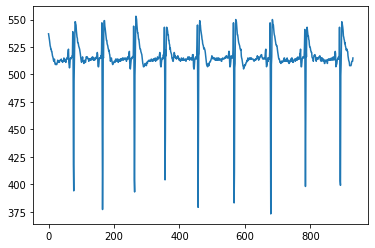

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(ecg_data)

In [4]:
len(ecg_data)

931